# A Tutorial for iDEA - interacting Dynamic Electrons Approach 

In this tutorial we will introduce you to the main functionality of iDEA. For more details, please see the full [API documentation](https://idea-interacting-dynamic-electrons-approach.readthedocs.io/en/latest/).

iDEA allows you to describe quantum mechanical systems in one dimension, and solve them for the required quantum state, from which you can calculate observables. The method to solve the system can be both exact, or a variety of common and novel approximate methods. These states can then be propagated due to perturbations, and such evolutions can be investigated. This allows you to both gain key insights from the exact solution, and by investigating failings of existing methods, investigate why such failings occur, and how to create new more accurate methods. In addition, iDEA can be used to create interactive visualisations of concepts from quantum mechanics and condensed matter physics, to create engaging teaching material. Also, the iDEA code, and its minimal dependencies are composed of fully free software and are highly optimised, and so can allow researchers to release notebooks with their papers, ensuring papers can be reproduces at the touch of a button. This also increases the extent to which readers can engage with your results. 

This tutorial will follow the following outline:
1. The "Hello World" of iDEA.
2. Describing Quantum Systems.
3. Solving Systems Exactly.
4. Computing Observables.
5. Perturbations and Time-Dependence.
6. Approximate Methods.
7. Reverse Engineering.
8. A full example: Investigating the 1D hydrogen molecule.

To install iDEA, simply use pip: `pip install iDEA-latest`.

Now we can import our dependencies for this tutorial:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import iDEA

## 1. The "Hello World" of iDEA.

When learning a new tool, it is always useful to try the simplest possible example.

In this case, we will use iDEA to determine **the ground-state charge density of the 2 electron atom in one-dimension.**

Firstly, iDEA has this as a built-in pre-defined system. Let us take this, and print it:

In [2]:
atom = iDEA.system.systems.atom
print(atom)

iDEA.system.System: x = np.array([-20.000,...,20.000]), dx = 0.1338..., v_ext = np.array([-0.095,...,-0.095]), electrons = ud


As we can see this system contains two electrons, one up-spin and one down-spin, as shown by `electrons = ud`. And it exists on a one-dimensional grid from $x=-20$ to $x=20$, with a grid spacing of $dx = 0.1338...$.

Let's plot the atom's external potential $V_{\mathrm{ext}}(x)$:

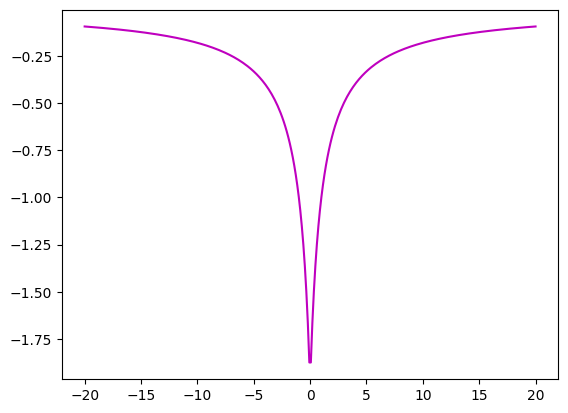

In [3]:
plt.plot(atom.x, atom.v_ext, 'm-')
plt.show()

This represents a softened Coloumb interaction to two protons located at $x=0$.

Now we have the atom described by an external potential, and containing two electrons, let use solve the system for its **ground-state** `(k=0)` to give the many-body wavefunction, which fully describes the quantum-mechanical system.

Since we want the exact solution, we will use the many-body `interacting` method, which treats the electron interaction exactly:

In [4]:
ground_state = iDEA.methods.interacting.solve(atom, k=0)

iDEA.methods.interacting.solve: solving eigenproblem...


This object contains the wavefunction of the state.

We can use the help function to see what this object contains.

In [5]:
help(ground_state)

Help on ManyBodyState in module iDEA.state object:

class ManyBodyState(State)
 |  ManyBodyState(space: numpy.ndarray = None, spin: numpy.ndarray = None, full=None, energy=None)
 |
 |  State of interacting particles.
 |
 |  Method resolution order:
 |      ManyBodyState
 |      State
 |      abc.ABC
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, space: numpy.ndarray = None, spin: numpy.ndarray = None, full=None, energy=None)
 |      State of particles in a many-body state.
 |
 |      This is described by a spatial part
 |      .. math:: \psi(x_1,x_2,\dots,x_N)
 |      on the spatial grid, and a spin
 |      part on the spin grid
 |      .. math:: \chi(\sigma_1,\sigma_2,\dots,\sigma_N).
 |      These are NOT necessarily antisymmetric states,
 |      they can be combined using the antisymmetrisation operaration to produce the full
 |      wavefunction
 |      .. math:: \Psi(x_1,\sigma_1,x_2,\sigma_2,\dots,x_N,\sigma_N).
 |
 |      | Args:
 |      |     space: 

As we can see, it contains three arrays: the space, spin and fully antisymmetrised wavefunction:

In [6]:
print(ground_state.space.shape)
print(ground_state.spin.shape)
print(ground_state.full.shape)

(300, 300)
(2, 2)
(300, 2, 300, 2)


As there are 300 grid points in our system, and 2 possibilities for spin, these shapes are what we expect.

We would now like to calculate our observable of interest: the charge density for the atom in it's ground-state. This is simply done as follows:

In [7]:
n = iDEA.observables.density(atom, state=ground_state)

Let's add that to our plot:

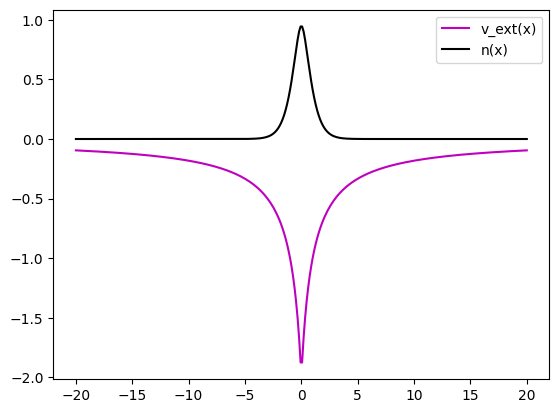

In [8]:
plt.plot(atom.x, atom.v_ext, 'm-', label='v_ext(x)')
plt.plot(atom.x, n, 'k-', label='n(x)')
plt.legend()
plt.show()

We can also compute the up and down spin-densities separately, and of course they are the same for this system:

In [9]:
n, up_n, down_n = iDEA.observables.density(atom, state=ground_state, return_spins=True)

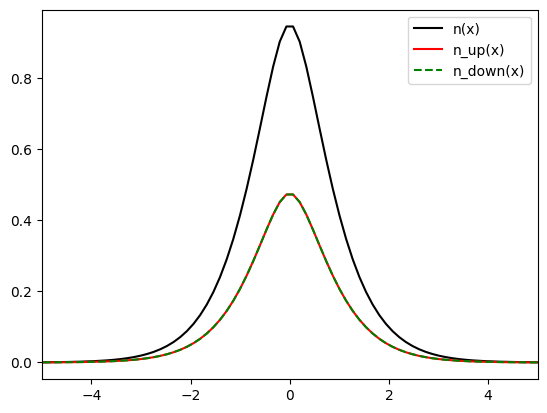

In [10]:
plt.plot(atom.x, n, 'k-', label='n(x)')
plt.plot(atom.x, up_n, 'r-', label='n_up(x)')
plt.plot(atom.x, down_n, 'g--', label='n_down(x)')
plt.xlim([-5.0, 5.0])
plt.legend()
plt.show()

There are many more observables we could compute. To see the full listing of any iDEA module, use the `dir` function:

In [11]:
dir(iDEA.observables)

['Union',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_placeholder',
 'copy',
 'density',
 'density_matrix',
 'exchange_energy',
 'exchange_potential',
 'external_energy',
 'external_potential',
 'hartree_energy',
 'hartree_potential',
 'iDEA',
 'itertools',
 'kinetic_energy',
 'np',
 'observable',
 'single_particle_energy',
 'string']

If you would like to analyse the source code of any particular part of iDEA, we can use `inspect`:

In [12]:
import inspect
print(inspect.getsource(iDEA.methods.non_interacting.kinetic_energy_operator))


def kinetic_energy_operator(s: iDEA.system.System) -> np.ndarray:
    r"""
    Compute single-particle kinetic energy operator as a matrix.

    This is built using a given number of finite differences to represent the second derivative.
    The number of differences taken is defined in s.stencil.

    | Args:
    |     s: iDEA.system.System, System object.

    | Returns:
    |     K: np.ndarray, Kintetic energy operator.
    """
    if s.stencil == 3:
        sd = 1.0 * np.array([1, -2, 1], dtype=float) / s.dx**2
        sdi = (-1, 0, 1)
    elif s.stencil == 5:
        sd = 1.0 / 12.0 * np.array([-1, 16, -30, 16, -1], dtype=float) / s.dx**2
        sdi = (-2, -1, 0, 1, 2)
    elif s.stencil == 7:
        sd = (
            1.0
            / 180.0
            * np.array([2, -27, 270, -490, 270, -27, 2], dtype=float)
            / s.dx**2
        )
        sdi = (-3, -2, -1, 0, 1, 2, 3)
    elif s.stencil == 9:
        sd = (
            1.0
            / 5040.0
            * np.array

## 2. Describing Quantum Systems.

In the simple example in the last section we used a pre-defined system. In this section, we will show you how to define any custom 1D quantum system. 

In iDEA, a quantum system is defined by:
- A spatial grid.
- An external potential.
- An electronic interaction.
- A given number of up and down spin electrons.

We can see the details using the `help` function:

In [13]:
help(iDEA.system.System
    )

Help on class System in module iDEA.system:

class System(builtins.object)
 |  System(x: numpy.ndarray, v_ext: numpy.ndarray, v_int: numpy.ndarray, electrons: str, stencil: int = 13)
 |
 |  Model system, containing all defining properties.
 |
 |  Methods defined here:
 |
 |  __init__(self, x: numpy.ndarray, v_ext: numpy.ndarray, v_int: numpy.ndarray, electrons: str, stencil: int = 13)
 |      Model system, containing all defining properties.
 |
 |      | Args:
 |      |     x: np.ndarray, Grid of x values in 1D space.
 |      |     v_ext: np.ndarray, External potential on the grid of x values.
 |      |     v_int: np.ndarray, Interaction potential on the grid of x values.
 |      |     electrons: string, Electrons contained in the system.
 |      |     stencil: int, Stencil to use for derivatives on the grid of x values. (default = 13)
 |
 |      | Raises:
 |      |     AssertionError.
 |
 |  __str__(self)
 |      Return str(self).
 |
 |  check(self)
 |      Performs checks on system p

Let us define a system `s`, which contains two electrons (both spin-up) in a quantum harmonic oscillator (QHO).

First, let us define a x-grid from $x=-10$ to $x=10$ with $150$ grid points:

In [14]:
x = np.linspace(-10, 10, 150)

Now we can define the external potential of the QHO:

$V_\mathrm{ext}(x) = \frac{1}{2} \omega^2 x^2$ where $\omega=0.25$

In [15]:
v_ext = 0.5 * 0.25**2 * x**2

Now we will choose an interaction for our electrons on our grid. As this is 1D we choose the softened interaction, but other options are available *(including custom interactions to build hubbard systems.)*

In [16]:
v_int = iDEA.interactions.softened_interaction(x)

We can now build our system:

In [17]:
s = iDEA.system.System(x, v_ext, v_int, electrons='uu')
print(s)
print("number of electrons =", s.count)

iDEA.system.System: x = np.array([-10.000,...,10.000]), dx = 0.1342..., v_ext = np.array([3.125,...,3.125]), electrons = uu
number of electrons = 2


We can now plot our external potential:

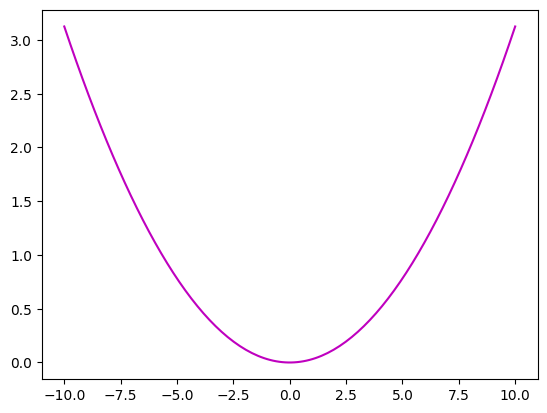

In [18]:
plt.plot(s.x, s.v_ext, 'm-')
plt.show()

And our interaction $V_\mathrm{int}(x,x')$:

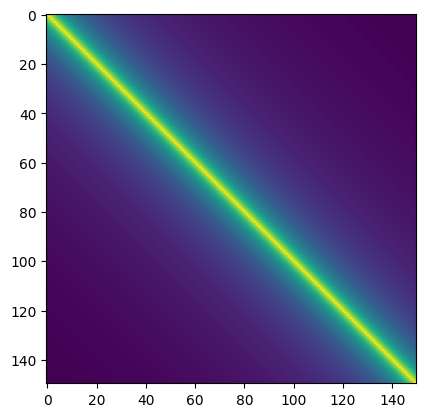

In [19]:
plt.imshow(v_int)
plt.show()

And to summarise, the code we used to build our system:

In [20]:
x = np.linspace(-10, 10, 150)
v_ext = 0.5 * 0.25**2 * x**2
v_int = iDEA.interactions.softened_interaction(x)
s = iDEA.system.System(x, v_ext, v_int, electrons='uu')

## 3. Solving Quantum Systems Exacly.

Now we have the description of our quantum system, we can use iDEA to solve the Schrödinger equation for the ground-state (`k=0`) of this system using the `interacting` module:

In [21]:
ground_state = iDEA.methods.interacting.solve(s, k=0)

iDEA.methods.interacting.solve: solving eigenproblem...


We can now use the spatial, spin and full wavefunctions to do any analysis we need:

In [22]:
print(ground_state.space.shape)
print(ground_state.spin.shape)
print(ground_state.full.shape)

(150, 150)
(2, 2)
(150, 2, 150, 2)


Since this is a two-electron system, we can actually plot the spacial part of the wavefunction directly in 2D:

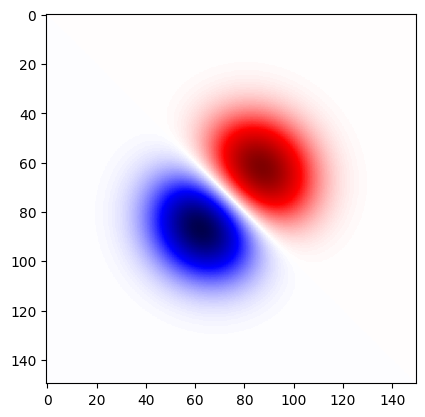

In [23]:
plt.imshow(ground_state.space.real, cmap="seismic", vmax=np.max(ground_state.space.real), vmin=-np.max(ground_state.space.real))
plt.show()

Note that this is zero along the diagonal, owing to the Pauli exclusion principle. (As an exercise, show this is not zero if the electrons have opposite spin. Hint: when building the system use `electrons = "ud"` instead of `"uu"`)

We can test that the wavefunction is antisymmetrised:

In [24]:
np.allclose(ground_state.full.real[80,0,50,0], -ground_state.full.real[50,0,80,0])

True

From this object we can also get the total energy:

In [25]:
print(ground_state.energy)

0.7531779444676757


We can also compute **any excited state** we would like. For example, the first excited state:

In [26]:
first_state = iDEA.methods.interacting.solve(s, k=1)

iDEA.methods.interacting.solve: solving eigenproblem...


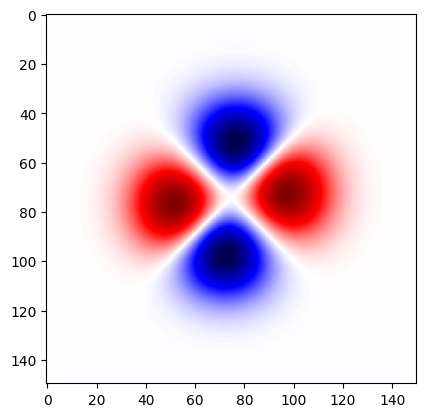

In [27]:
plt.imshow(first_state.space.real, cmap="seismic", vmax=np.max(first_state.space.real), vmin=-np.max(first_state.space.real))
plt.show()

We could use this to compute the **optical gap** of the system:

In [28]:
print("optical gap =", first_state.energy - ground_state.energy)

optical gap = 0.25000003959021055


## 4. Computing Observables.

Let us now turn to computing some common observables of our system, and visualising them:

In [29]:
n = iDEA.observables.density(s, state=ground_state)
v_h = iDEA.observables.hartree_potential(s, n)
E_h = iDEA.observables.hartree_energy(s, n, v_h)


p = iDEA.observables.density_matrix(s, state=ground_state)
v_x = iDEA.observables.exchange_potential(s, p)
E_x = iDEA.observables.exchange_energy(s, p, v_x)


print("hartree energy =", E_h, ", exchange energy =", E_x)

hartree energy = 0.758566297083547 , exchange energy = -0.5146141349952196


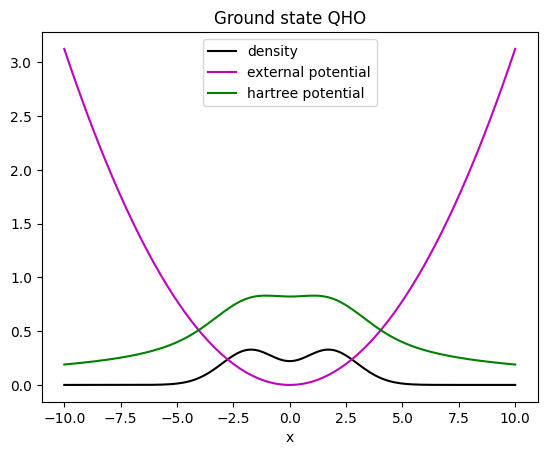

In [30]:
plt.plot(s.x, n, 'k-', label="density")
plt.plot(s.x, s.v_ext, 'm-', label="external potential")
plt.plot(s.x, v_h, 'g-', label="hartree potential")
plt.legend()
plt.xlabel("x")
plt.title("Ground state QHO")
plt.show()

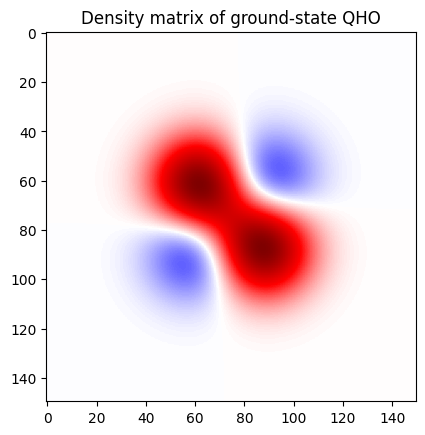

In [31]:
plt.imshow(p, cmap="seismic", vmax=np.max(p), vmin=-np.max(p))
plt.title("Density matrix of ground-state QHO")
plt.show()

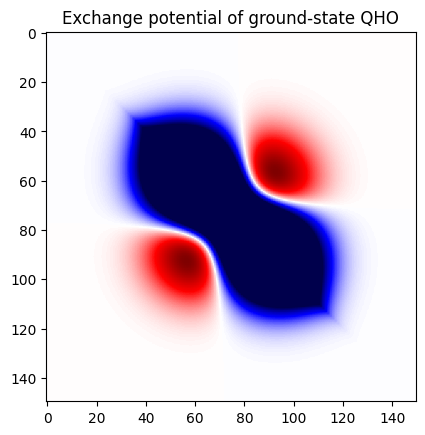

In [32]:
plt.imshow(v_x, cmap="seismic", vmax=np.max(v_x), vmin=-np.max(v_x))
plt.title("Exchange potential of ground-state QHO")
plt.show()

And we can of course repeat the above for the first excited-state:

In [33]:
n = iDEA.observables.density(s, state=first_state)
v_h = iDEA.observables.hartree_potential(s, n)
E_h = iDEA.observables.hartree_energy(s, n, v_h)


p = iDEA.observables.density_matrix(s, state=first_state)
v_x = iDEA.observables.exchange_potential(s, p)
E_x = iDEA.observables.exchange_energy(s, p, v_x)


print("hartree energy =", E_h, ", exchange energy =", E_x)

hartree energy = 0.6990259617571027 , exchange energy = -0.4397489413446024


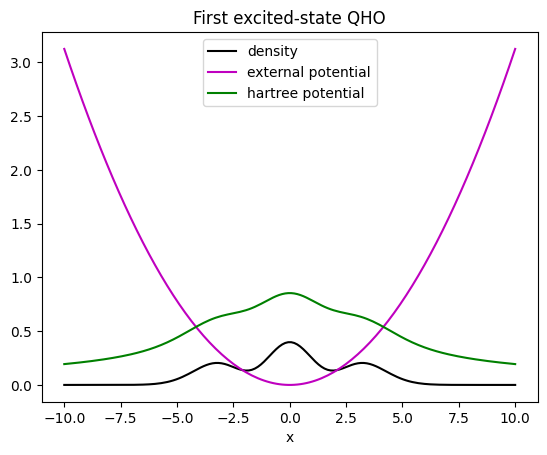

In [34]:
plt.plot(s.x, n, 'k-', label="density")
plt.plot(s.x, s.v_ext, 'm-', label="external potential")
plt.plot(s.x, v_h, 'g-', label="hartree potential")
plt.legend()
plt.xlabel("x")
plt.title("First excited-state QHO")
plt.show()

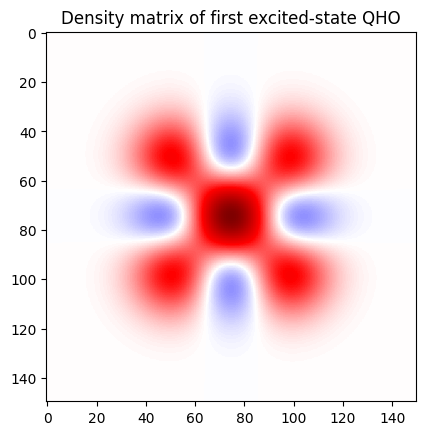

In [35]:
plt.imshow(p, cmap="seismic", vmax=np.max(p), vmin=-np.max(p))
plt.title("Density matrix of first excited-state QHO")
plt.show()

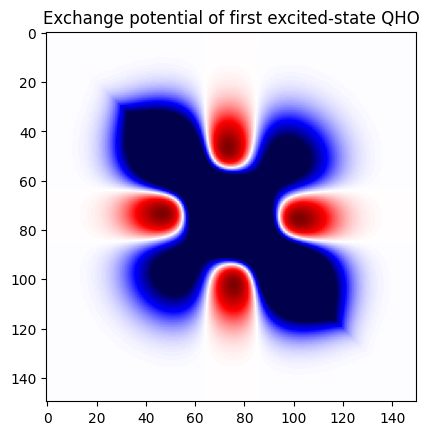

In [36]:
plt.imshow(v_x, cmap="seismic", vmax=np.max(v_x), vmin=-np.max(v_x))
plt.title("Exchange potential of first excited-state QHO")
plt.show()

## 5. Perturbations and Time-Dependence.

Now we know how to; describe systems, solve them for given states, and compute observables, we can now look at driving these systems out of thier stationary states using a external perturbation.

First we define a time grid $t=0 \rightarrow t=100$: wih $1000$ timesteps:

In [37]:
t = np.linspace(0, 50, 500)

For our perturbation, we choose a oscillating linear electric field:

In [38]:
v_ptrb = np.zeros(shape=t.shape+x.shape)
for j, ti in enumerate(t):
    v_ptrb[j,:] = -0.1 * x * np.sin(0.5*ti)

We can animate our field:

RuntimeError: Requested MovieWriter (ffmpeg) not available

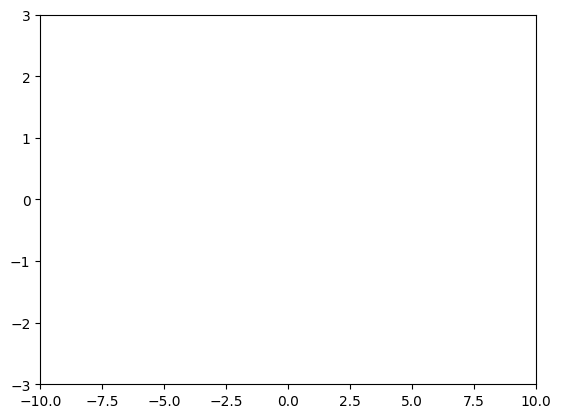

In [39]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
fig = plt.figure()
ax = plt.axes(xlim=(s.x[0], s.x[-1]), ylim=(-3.0, 3.0))
line1, = ax.plot([], [], lw=2, c='m')
line2, = ax.plot([], [], lw=2, c='r', ls='--')
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2
def animate(i):
    line1.set_data(s.x, v_ptrb[i,:])
    line2.set_data(s.x, v_ptrb[i,:])
    return line1, line2
anim = FuncAnimation(fig, animate, init_func=init, frames=100, interval=10, blit=True)
HTML(anim.to_html5_video())

To propagate our ground-state, due to this perturbation: *(this can take some time on slower machine, to speed up simply reduce the number of timesteps)*

In [40]:
evolution = iDEA.methods.interacting.propagate(s, ground_state, v_ptrb, t)

iDEA.methods.interacting.propagate: propagating state: 100%|██████████| 500/500 [01:36<00:00,  5.16it/s]


From this evolution, we can compute dynamic observables in much the same way as previously.

In [41]:
n = iDEA.observables.density(s, evolution=evolution)
v_h = iDEA.observables.hartree_potential(s, n)
E_h = iDEA.observables.hartree_energy(s, n, v_h)


p = iDEA.observables.density_matrix(s, evolution=evolution)
v_x = iDEA.observables.exchange_potential(s, p)
E_x = iDEA.observables.exchange_energy(s, p, v_x)

RuntimeError: Requested MovieWriter (ffmpeg) not available

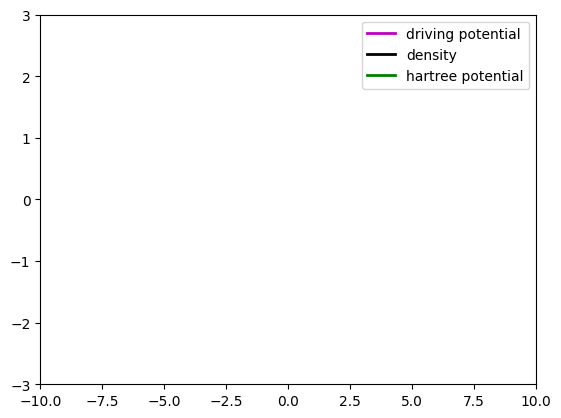

In [42]:
fig = plt.figure()
ax = plt.axes(xlim=(s.x[0], s.x[-1]), ylim=(-3.0, 3.0))
line1, = ax.plot([], [], lw=2, c='m', label="driving potential")
line2, = ax.plot([], [], lw=2, c='k', label="density")
line3, = ax.plot([], [], lw=2, c='g', label="hartree potential")
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    return line1, line2, line3
def animate(i):
    line1.set_data(s.x, s.v_ext[:] + v_ptrb[i,:])
    line2.set_data(s.x, n[i,:])
    line3.set_data(s.x, v_h[i,:])
    return line1, line2, line3
plt.legend()
anim = FuncAnimation(fig, animate, init_func=init, frames=100, interval=10, blit=True)
HTML(anim.to_html5_video())

## 6. Approximate Methods.

As well as the exact solution, we can also compute everything we have in the previous sections, but with common approximations. To see the current list of approximations (more are added each release!) we can use the `dir` function.

In [43]:
dir(iDEA.methods)

['Enum',
 'Methods',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'hartree',
 'hartree_fock',
 'hybrid',
 'interacting',
 'lda',
 'non_interacting']

We can investigate a given method in a little more detail:

In [44]:
help(iDEA.methods.hartree_fock)

Help on module iDEA.methods.hartree_fock in iDEA.methods:

NAME
    iDEA.methods.hartree_fock - Contains all Hartree Fock functionality and solvers.

FUNCTIONS
    exchange_potential_operator(s: iDEA.system.System, p: numpy.ndarray) -> numpy.ndarray
        Compute the exchange potential operator.

        | Args:
        |     s: iDEA.system.System, System object.
        |     p: np.ndarray, Charge density matrix.

        | Returns:
        |     Vx: np.ndarray, Exchange potential energy operator.

    hamiltonian(s: iDEA.system.System, up_n: numpy.ndarray, down_n: numpy.ndarray, up_p: numpy.ndarray, down_p: numpy.ndarray, K: numpy.ndarray = None, Vext: numpy.ndarray = None) -> numpy.ndarray
        Compute the Hamiltonian from the kinetic and potential terms.

        | Args:
        |     s: iDEA.system.System, System object.
        |     up_n: np.ndarray, Charge density of up electrons.
        |     down_n: np.ndarray, Charge density of down electrons.
        |     up_p: np.nd

We can solve our system using **LDA** and compare this to our exact result:

In [45]:
ground_state_lda = iDEA.methods.lda.solve(s, k=0)

iDEA.methods.lda.solve: convergence = 6.9327e-11, tolerance = 1e-10


In [46]:
n_exact = iDEA.observables.density(s, state=ground_state)

In [47]:
n_lda = iDEA.observables.density(s, state=ground_state_lda)

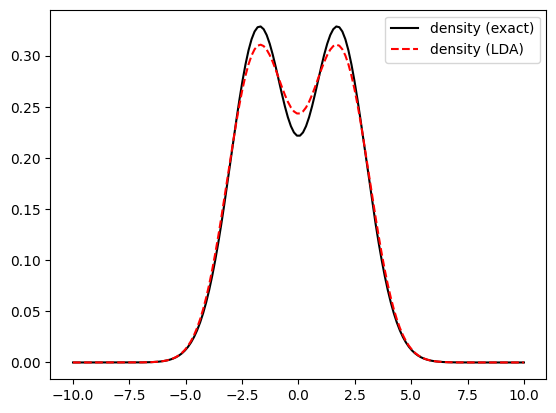

In [48]:
plt.plot(s.x, n_exact, "k-", label="density (exact)")
plt.plot(s.x, n_lda, "r--", label="density (LDA)")
plt.legend()
plt.show()

`iDEA` makes it easy to compare many different approximations. For example, **we can compare the first-excited state charge density, for the two electron (ud) QHO for all of the methods using the following simple code:**

iDEA.methods.interacting.solve: solving eigenproblem...
iDEA.methods.non_interacting.solve: convergence = 9.0922e-12, tolerance = 1e-06
iDEA.methods.hartree.solve: convergence = 7.6081e-07, tolerance = 1e-06
iDEA.methods.hartree_fock.solve: convergence = 7.9506e-07, tolerance = 1e-06
iDEA.methods.lda.solve: convergence = 9.5944e-07, tolerance = 1e-06
iDEA.methods.hybrid.solve: convergence = 8.8926e-07, tolerance = 1e-06


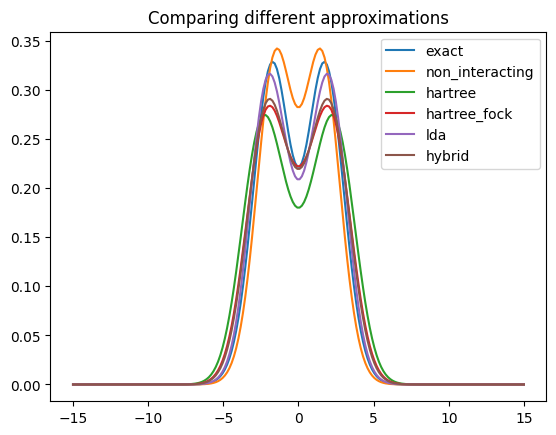

In [49]:
x = np.linspace(-15, 15, 200)
v_ext = 0.5 * 0.25**2 * x**2
v_int = iDEA.interactions.softened_interaction(x)
s = iDEA.system.System(x, v_ext, v_int, electrons='ud')


state_exact = iDEA.methods.interacting.solve(s, k=1)
n_exact = iDEA.observables.density(s, state_exact)
plt.plot(s.x, n_exact, label="exact")

for method in iDEA.iterate_sb_methods:
    state = method.solve(s, k=1, tol=1e-6)
    n = iDEA.observables.density(s, state)
    plt.plot(s.x, n, label=method.name)
plt.title("Comparing different approximations")
plt.legend()
plt.show()

## 7. Reverse Engineering.

`iDEA` also gives you the ability to reverse-engineer charge densities. **This tells you what fictitious system would need to be solved using a given method, to reproduce a target density.**

The reverse function provides this functionality:

In [50]:
help(iDEA.reverse_engineering.reverse)

Help on function reverse in module iDEA.reverse_engineering:

reverse(s: iDEA.system.System, target_n: numpy.ndarray, method: collections.abc.Container, v_guess: numpy.ndarray = None, mu: float = 1.0, pe: float = 0.1, tol: float = 1e-12, silent: bool = False, **kwargs) -> iDEA.state.State
    Determines what ficticious system is needed for a given method, when solving the system, to produce a given target density.
    If the given target density is from solving the interacting electron problem (iDEA.methods.interacting), and the method is the non-interacting electron solver (iDEA.methods.non_interacting)
    the output is the Kohn-Sham system.

    The iterative method used is defined by the following formula:
    .. math:: \mathrm{V}_\mathrm{ext} \rightarrow \mu * (\mathrm{n}^p - \mathrm{target_n}^p)

    | Args:
    |     s: iDEA.system.System, System object.
    |     target_n: np.ndarray, Target density to reverse engineer.
    |     method: Container, The method used to solve the 

This is a general method, but can be used to perform many common tasks in condensed matter physics.

For example, we can determine the exact Kohn-Sham (KS) and exchange-correlation (xc) potential of a system, by asking: **What fictitious system, when solved with the non-interacting method, gives us the same density as that solved by the interacting method.** The external potential of this fictitious system is none other than the exact KS potential, from which the exact xc potential can be found:

iDEA.methods.interacting.solve: solving eigenproblem...
iDEA.reverse_engineering.reverse: convergence = 1.0696e-12, tolerance = 1e-12
iDEA.methods.non_interacting.solve: convergence = 6.7313e-12, tolerance = 1e-10


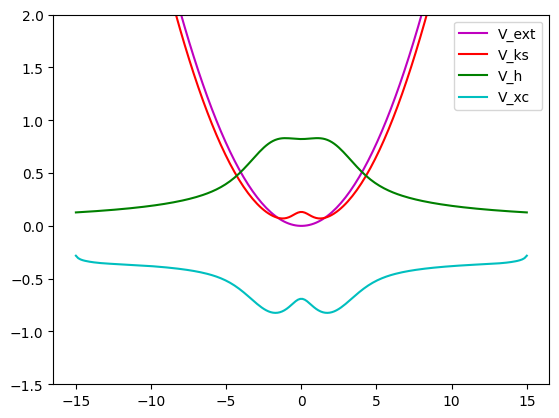

In [51]:
x = np.linspace(-15, 15, 200)
v_ext = 0.5 * 0.25**2 * x**2
v_int = iDEA.interactions.softened_interaction(x)
s = iDEA.system.System(x, v_ext, v_int, electrons='uu')


state = iDEA.methods.interacting.solve(s, k=0)
n = iDEA.observables.density(s, state)


s_fictitious = iDEA.reverse_engineering.reverse(s, target_n=n, method=iDEA.methods.non_interacting)
state_fictitious = iDEA.methods.non_interacting.solve(s_fictitious, k=0)


v_ks = s_fictitious.v_ext
n_fictitious = iDEA.observables.density(s, state_fictitious)
v_h = iDEA.observables.hartree_potential(s_fictitious, n_fictitious)
v_xc = v_ks - s.v_ext - v_h


plt.plot(s_fictitious.x, s.v_ext, 'm-', label="V_ext")
plt.plot(s_fictitious.x, v_ks, 'r-', label="V_ks")
plt.plot(s_fictitious.x, v_h, 'g-', label="V_h")
plt.plot(s_fictitious.x, v_xc, 'c-', label="V_xc")
plt.legend()
plt.ylim([-1.5, 2.0])
plt.show()

Reverse-engineering can also be used to determine what time-dependent potential is needed in a fictitious evolution, in order to recover a given target density. A full example of this is shown below:

In [ ]:
import scipy.special as spspec

x = np.linspace(-10, 10, 100)
v_ext = -2.0 / (abs(x) + 1.0)
v_int = iDEA.interactions.softened_interaction(x)
electrons = 'uu'
s = iDEA.system.System(x, v_ext, v_int, electrons)


t = np.linspace(0, 10, 100)
v_ptrb = np.zeros(shape=t.shape+x.shape)
for j, ti in enumerate(t):
    v_ptrb[j,:] = -0.1 * x * 0.5*(spspec.erf(ti - 2.0) + 1.0)


state = iDEA.methods.interacting.solve(s, k=0)
target_n = iDEA.observables.density(s, state=state)
s_fictitious = iDEA.reverse_engineering.reverse(s, target_n, method=iDEA.methods.non_interacting)
state_fictitious = iDEA.methods.non_interacting.solve(s_fictitious)


evolution = iDEA.methods.interacting.propagate(s, state, v_ptrb, t)
target_n = iDEA.observables.density(s, evolution=evolution)
evolution_fictitious, error = iDEA.reverse_engineering.reverse_propagation(s_fictitious, state_fictitious, target_n, iDEA.methods.non_interacting, v_ptrb, t)
evolution_fictitious = iDEA.methods.non_interacting.propagate(s_fictitious, state_fictitious, evolution_fictitious.v_ptrb, t)


for ti in range( len(t) ):
    evolution_fictitious.v_ptrb[ti,:] -= evolution_fictitious.v_ptrb[ti,int(0.5*len(x))]


n = iDEA.observables.density(s, evolution=evolution_fictitious)
v_ext = iDEA.observables.external_potential(s)
v_h = iDEA.observables.hartree_potential(s, n)


fig = plt.figure()
ax = plt.axes(xlim=(s.x[0], s.x[-1]), ylim=(-3.0, 3.0))
line1, = ax.plot([], [], lw=2, c="k", label="target density")
line2, = ax.plot([], [], lw=2, c="r", ls="--", label="fictitious density")
line3, = ax.plot([], [], lw=2, c="c", label="exact KS potential")
line4, = ax.plot([], [], lw=2, c="g", ls="--", label="driving potential")
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])
    return line1, line2, line3, line4
def animate(i):
    line1.set_data(s.x, n[i,:])
    line2.set_data(s.x, target_n[i,:])
    line3.set_data(s.x, evolution_fictitious.v_ptrb[i,:])
    line4.set_data(s.x, v_ptrb[i,:])
    return line1, line2, line3, line4
plt.legend()
anim = FuncAnimation(fig, animate, init_func=init, frames=100, interval=10, blit=True)
HTML(anim.to_html5_video())

## 8. A full example: Investigating 1D hydrogen molecule.

Now you know all the basics of using iDEA to investigate and simulate quantum systems, here we will show you a "real-world" example.

**In the following section of code, we will compute the exact bonding curve of the 1D hydrogen molecule, and compare it to a conventional figure.**

In [ ]:
# Build the base system.
x = np.linspace(-10, 10, 200)
v_ext = np.zeros_like(x) 
v_int = iDEA.interactions.softened_interaction(x)
electrons = 'ud'
s = iDEA.system.System(x, v_ext, v_int, electrons)


# Function to build the hydrogen molecule at each given distance d.
d = 8.0
def v(x):
    return -1.0/(np.abs(x + 0.5*d) + 1.0) -1.0/(np.abs(x - 0.5*d) + 1.0)


# Define range of bond distances.
distances = np.linspace(0.0, 8.0, 50)
energies = np.zeros_like(distances)


# Compute exact electron energy at each distance.
for i in range(distances.shape[0]):
    d = distances[i]
    print('distance = {0}'.format(d))
    s.v_ext = np.copy(v(x))                     
    state = iDEA.methods.interacting.solve(s)
    energies[i] = state.energy


# Add the proton energy.
E_proton = 1.0 / (np.abs(distances) + 1.0)
energies += E_proton


# Plot energy curve.
plt.axhline(y=-1.0, xmin=0.0, xmax=8.2, linewidth=1, color='k')
plt.plot(distances, energies, linestyle='-', color='k', linewidth=2)
plt.xlabel('distance (a.u.)', size=25)
plt.ylabel('E (a.u.)', size=25)
plt.tick_params(top='on', right='on')
plt.tick_params(direction='in')
plt.gcf().subplots_adjust(left=0.18)
plt.gcf().subplots_adjust(bottom=0.18)
plt.plot()

We can see this follows the expected curve:

![Curve](diagram.png)

Now we recommend, using the tools we have walked through in this tutorial, you gain more experience with the iDEA code by trying to solve some of these more advanced open-ended problems:

1. What does the bonding curve from part 8 look like if the electrons have the same spin?
2. What is the exact xc potential for the three electron 1D lithium atom.
3. Which approximation yields the most accurate density matrix for the QHO.
4. What kind of field is needed to ionise an electron out of an atom in real time?
5. Can you modify the occupations of a Hartree-Fock calculation, to yield the exact density?